In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from NetEmbs import *
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["figure.figsize"] = [20,10]

In [3]:
embs = pd.read_pickle("model/tmps/tmp_dataMarcel.pkl")

In [4]:
embs.head()

ID                                                Emb       GroundTruth
0   1  [0.20982003, 0.16462544, -0.1539455, -0.154151...          Purchase
1   3  [-0.19971998, 0.38667735, 0.02246202, 0.154739...      Sales 21 btw
2   4  [0.16549358, -0.20079182, 0.38595855, -0.10701...     Cost of Sales
3   5  [-0.18310927, -0.14398952, -0.0246522, 0.01622...      Fixed Assets
4   6  [-0.22611028, 0.023601333, 0.11976176, -0.1576...  Tax disbursement

Collections


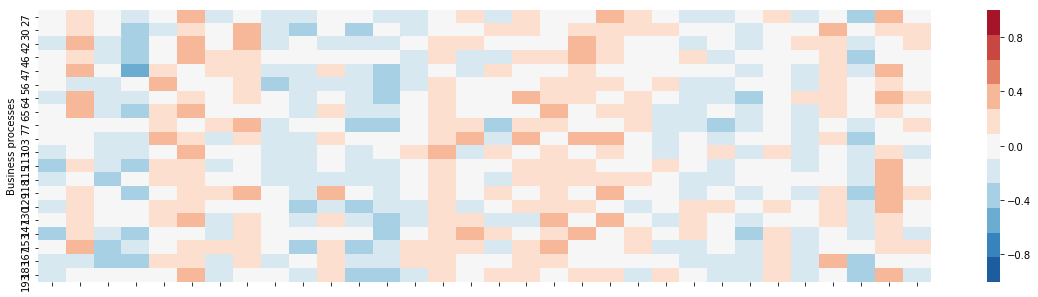

/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Cost of Sales


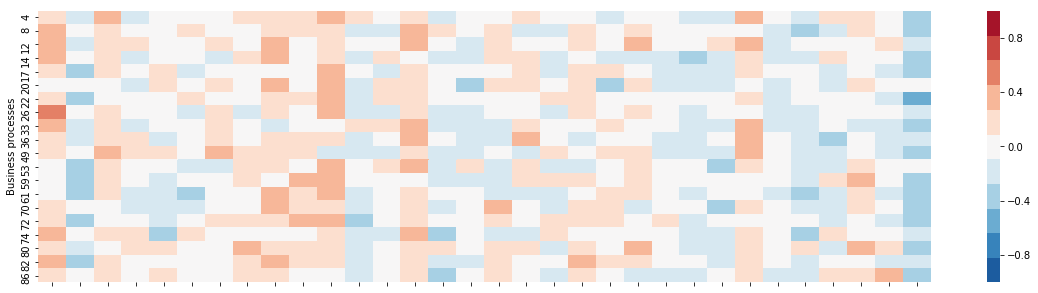

Depreciation


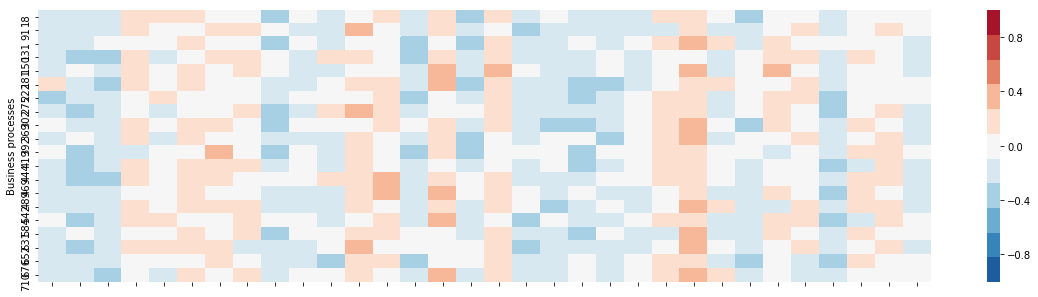

Fixed Assets


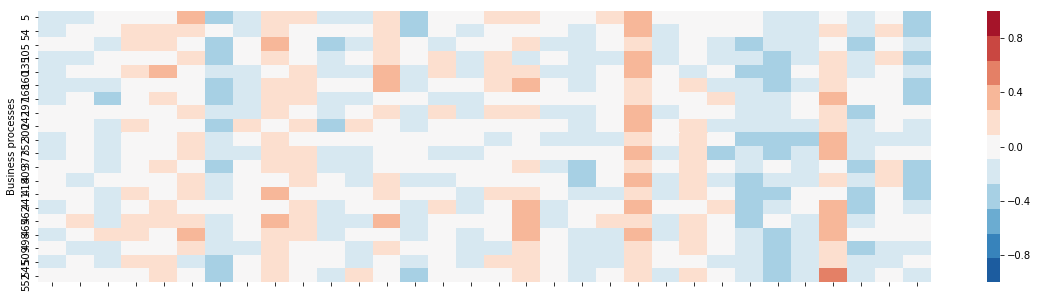

Payroll


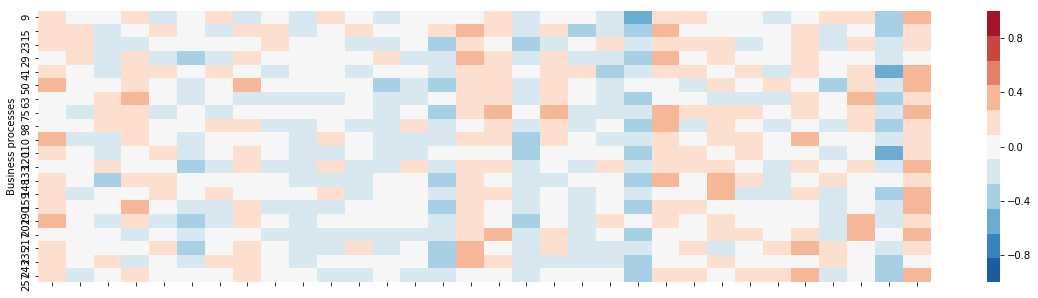

Payroll Disbursement
Not enough samples...
Purchase


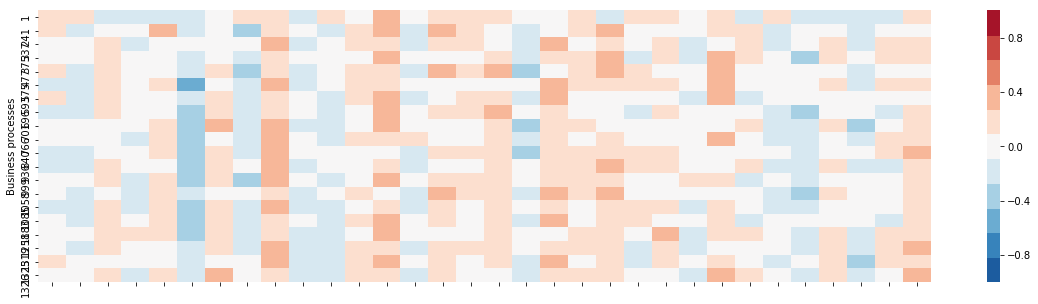

Sales 21 btw


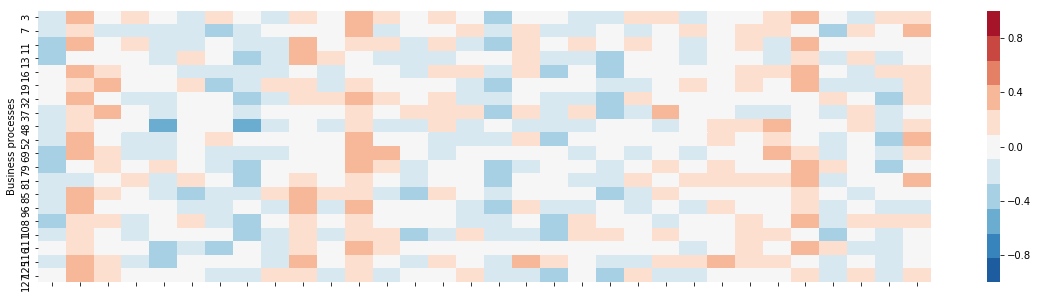

Sales 6 btw


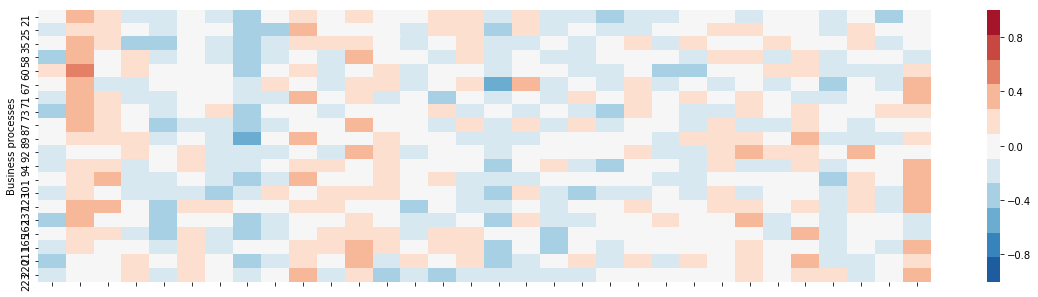

Tax disbursement
Not enough samples...


In [5]:
dims = 20
ns = 11
sm_embs = pd.DataFrame(columns=list(embs)+["Legend"])
for name, group in embs.groupby("GroundTruth"):
    print(name)
    if group.shape[0] > 3:
        plt.figure(figsize=(20, 5))
        sns.heatmap(list(group["Emb"].values[:dims]), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 11))
        frame1 = plt.gca()
        frame1.axes.set_xlabel('')
        frame1.axes.set_ylabel('Business processes')
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels(list(group["ID"].values[:dims]))
        plt.show()
        app = group.head(ns).copy()
#         app["Legend"] = np.array([None, None, group["GroundTruth"].values[0], None, None])
        sm_embs = sm_embs.append(app).append(pd.DataFrame({"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}))
    else:
        print("Not enough samples...")

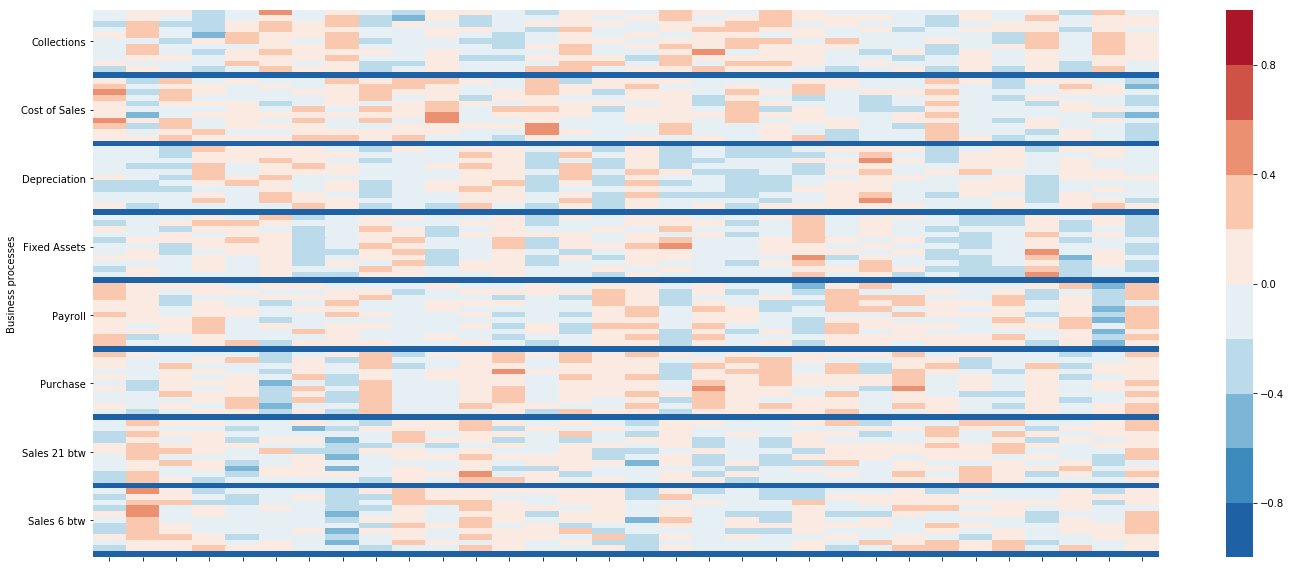

In [9]:
# sm_embs = embs.head(50).sort_values("GroundTruth")
title="vectors_vis_batch128_0905"
import matplotlib.ticker as ticker
plt.figure(figsize=(20, 8))
t_ax = sns.heatmap(list(sm_embs["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 10))
frame1 = plt.gca()
frame1.axes.set_xlabel('')
frame1.axes.set_ylabel('Business processes')
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels(list(sm_embs["GroundTruth"].dropna().unique()), rotation='horizontal')
frame1.axes.yaxis.set_major_locator(ticker.FixedLocator([ns/2+it*(ns+1) for it in range(8)]))
plt.rc('axes', titlesize=18)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.tight_layout()
plt.savefig("img/" + title, dpi=140, pad_inches=0.01)

In [78]:
def plotVectors(df, title="Vectors"):
    import matplotlib.ticker as ticker
    plt.figure(figsize=(20, 8))
    t_ax = sns.heatmap(list(df["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 10))
    frame1 = plt.gca()
    frame1.axes.set_xlabel('')
    frame1.axes.set_ylabel('Business processes')
    frame1.axes.xaxis.set_ticklabels([])
    ns = np.where(df.GroundTruth.values==None)[0][0]
    frame1.axes.yaxis.set_ticklabels(list(df["GroundTruth"].dropna().unique()), rotation='horizontal')
    frame1.axes.yaxis.set_major_locator(ticker.FixedLocator([ns/2+it*(ns+1) for it in range(8)]))
    plt.rc('axes', titlesize=18)  # fontsize of the x and y titles
    plt.rc('axes', labelsize=18)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
    postfix = "_emb_size"+str(len(df["Emb"].values[0]))+"samples_per_group"+str(ns)
    plt.tight_layout()
    plt.savefig("img/" + title+postfix, dpi=140, pad_inches=0.01)

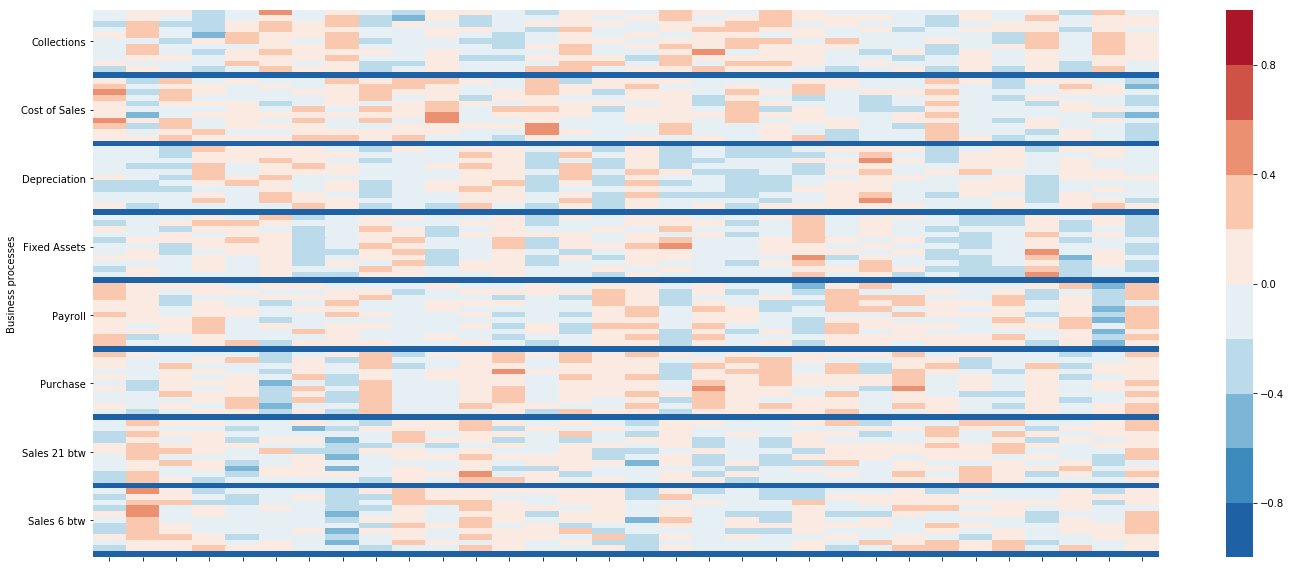

In [6]:
plotVectors(sm_embs)

For group  Payroll Disbursement  is not enough samples...
For group  Tax disbursement  is not enough samples...


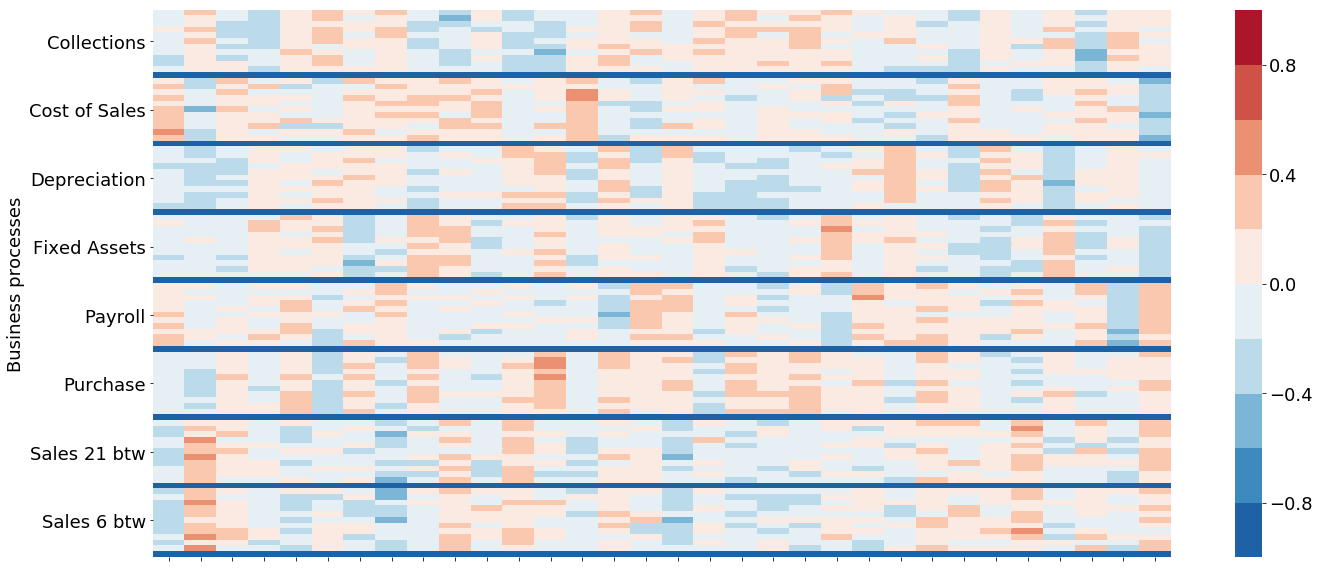

In [26]:
def groupVectors(df, how="median", samples_per_group=11, print_info=False):
    means = dict()
    pretty_vectors = pd.DataFrame(columns=list(df))
    for name, group in df.groupby("GroundTruth"):
        if group.shape[0] > samples_per_group:
            cur_data = group.copy()
            if how=="mean":
                means[name] = np.mean(group["Emb"].values, axis=0)
            elif how=="median":
                means[name]=np.median(group["Emb"].values.tolist(), axis=0)
            elif how=="random":
                means[name]=group["Emb"].values[0]
            cur_data["Similarity"] = cur_data["Emb"].apply(lambda x: 
                                                     cosine_similarity(X=means[name].reshape(1, -1), Y=x.reshape(1, -1)))
            cur_data.sort_values("Similarity", ascending=False, axis=0, inplace=True)
            if print_info:
                print("-----"+name+"-----")
                print("Highest similarity: \n", cur_data.Similarity.head(2), "\nLowest similarity: \n", cur_data.Similarity.tail(2))
            app = cur_data.head(samples_per_group).copy()
            pretty_vectors = pretty_vectors.append(app, sort=True).append(pd.DataFrame(
                {"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}), sort=False)
        else:
            print("For group ", name, " is not enough samples...")
    return pretty_vectors

plotVectors(groupVectors(embs, how="mean"), title="prettyVectorsMean")

For group  Payroll Disbursement  is not enough samples...
For group  Tax disbursement  is not enough samples...


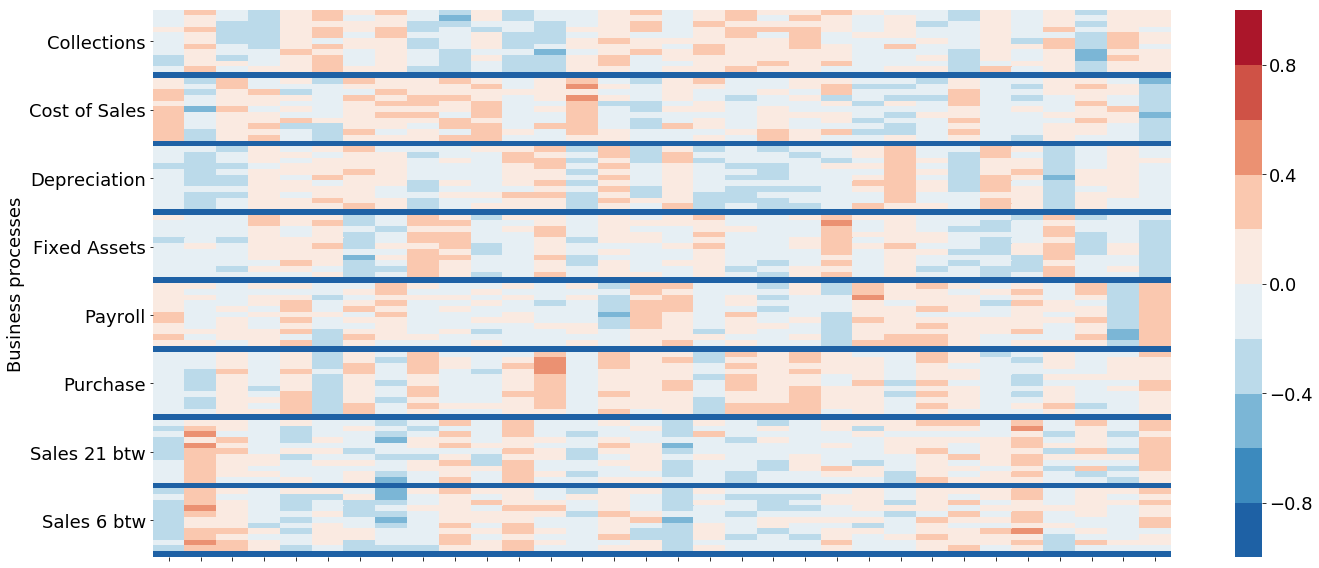

In [10]:
plotVectors(groupVectors(embs, how="median"), title="prettyVectors_median")

## Clustering score

### V-Score

In [5]:
from sklearn.metrics import v_measure_score

In [6]:
cl_data = cl_Agglomerative(embs, 9)

First row of Data: 
 [ 0.20982003  0.16462544 -0.15394551 -0.15415113 -0.18864574 -0.26675463
 -0.08083268  0.10281872  0.23383135 -0.26248536  0.12544529  0.08378573
  0.31039923  0.07646751  0.2392673   0.1405607   0.22745202  0.01175076
 -0.06798675  0.16846085 -0.16137084  0.18566883  0.15066996  0.07055464
  0.22347216 -0.16458535  0.19479321 -0.11342054 -0.10659097 -0.25814846
 -0.11081155  0.20209676]


In [7]:
str_labels = list(cl_data.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
real_labels

{'Purchase': 0,
 'Sales 21 btw': 1,
 'Cost of Sales': 2,
 'Fixed Assets': 3,
 'Tax disbursement': 4,
 'Payroll': 5,
 'Payroll Disbursement': 6,
 'Depreciation': 7,
 'Sales 6 btw': 8,
 'Collections': 9}

In [8]:
cl_data["true_labels"] = cl_data.GroundTruth.apply(lambda x: real_labels[x])

In [14]:
cl_data.head(3)

ID                                                Emb    GroundTruth  label
0   1  [0.20982003, 0.16462544, -0.1539455, -0.154151...       Purchase      6
1   3  [-0.19971998, 0.38667735, 0.02246202, 0.154739...   Sales 21 btw      8
2   4  [0.16549358, -0.20079182, 0.38595855, -0.10701...  Cost of Sales      0

In [10]:
v_measure_score(cl_data.true_labels.values, cl_data.label.values)

0.8781972170257953

In [11]:
from collections import Counter
cl_data = cl_Agglomerative(embs, 9)
for name, group in cl_data.groupby("GroundTruth"):
    print(name)
    cnt = dict(Counter(group.label.values.tolist()))
    print(cnt)
print("-------------")
for name, group in cl_data.groupby("label"):
    print(name)
    cnt = dict(Counter(group.GroundTruth.values.tolist()))
    print(cnt)

First row of Data: 
 [ 0.20982003  0.16462544 -0.15394551 -0.15415113 -0.18864574 -0.26675463
 -0.08083268  0.10281872  0.23383135 -0.26248536  0.12544529  0.08378573
  0.31039923  0.07646751  0.2392673   0.1405607   0.22745202  0.01175076
 -0.06798675  0.16846085 -0.16137084  0.18566883  0.15066996  0.07055464
  0.22347216 -0.16458535  0.19479321 -0.11342054 -0.10659097 -0.25814846
 -0.11081155  0.20209676]
Collections
{4: 1172}
Cost of Sales
{0: 1661}
Depreciation
{5: 410}
Fixed Assets
{7: 430}
Payroll
{3: 1060}
Payroll Disbursement
{1: 1}
Purchase
{6: 236}
Sales 21 btw
{8: 238, 1: 306, 2: 412}
Sales 6 btw
{1: 292, 2: 403, 8: 222}
Tax disbursement
{1: 1}
-------------
0
{'Cost of Sales': 1661}
1
{'Tax disbursement': 1, 'Sales 21 btw': 306, 'Payroll Disbursement': 1, 'Sales 6 btw': 292}
2
{'Sales 21 btw': 412, 'Sales 6 btw': 403}
3
{'Payroll': 1060}
4
{'Collections': 1172}
5
{'Depreciation': 410}
6
{'Purchase': 236}
7
{'Fixed Assets': 430}
8
{'Sales 21 btw': 238, 'Sales 6 btw': 222}


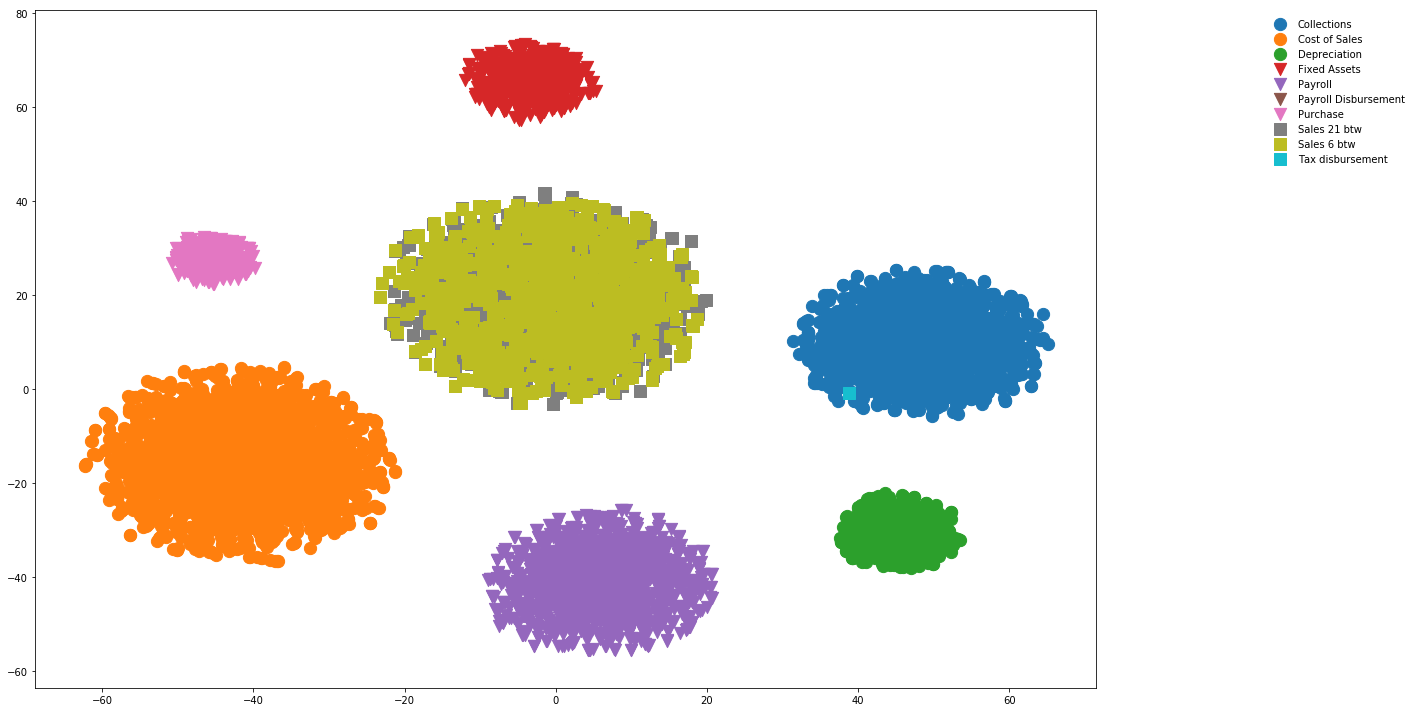

In [10]:
plot_tSNE(cl_data, legend_title="GroundTruth", title="Marcel/output_test")

In [13]:
cl_data.head(10)

ID                                                Emb  \
0   1  [0.20982003, 0.16462544, -0.1539455, -0.154151...   
1   3  [-0.19971998, 0.38667735, 0.02246202, 0.154739...   
2   4  [0.16549358, -0.20079182, 0.38595855, -0.10701...   
3   5  [-0.18310927, -0.14398952, -0.0246522, 0.01622...   
4   6  [-0.22611028, 0.023601333, 0.11976176, -0.1576...   
5   7  [-0.1421038, 0.097384244, -0.10727074, -0.1035...   
6   8  [0.34771866, -0.0021104268, 0.1441958, 0.03595...   
7   9  [0.20392513, 0.08858089, 0.024737159, 0.117574...   
8  10  [-0.1353511, -0.20830451, -0.18160547, -0.1621...   
9  11  [-0.27796566, 0.37483886, 0.08016002, 0.108949...   

            GroundTruth  label  
0              Purchase      6  
1          Sales 21 btw      8  
2         Cost of Sales      0  
3          Fixed Assets      7  
4      Tax disbursement      1  
5          Sales 21 btw      1  
6         Cost of Sales      0  
7               Payroll      3  
8  Payroll Disbursement      1  
9          Sales 21 btw      8

In [33]:
from collections import Counter
pred_labels = sorted(list(cl_data.label.unique()))
true_labels = sorted(list(cl_data.GroundTruth.unique()))
confuse_me = dict().fromkeys(pred_labels, dict().fromkeys(true_labels, 0))
for name, group in cl_data.groupby("label"):
    cnt = dict(Counter(group.GroundTruth.values.tolist()))
    tmp = confuse_me[name].copy()
    tmp.update(cnt)
    confuse_me[name]=tmp

In [34]:
confuse_me

{0: {'Collections': 0,
  'Cost of Sales': 1661,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbursement': 0,
  'Purchase': 0,
  'Sales 21 btw': 0,
  'Sales 6 btw': 0,
  'Tax disbursement': 0},
 1: {'Collections': 0,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbursement': 1,
  'Purchase': 0,
  'Sales 21 btw': 306,
  'Sales 6 btw': 292,
  'Tax disbursement': 1},
 2: {'Collections': 0,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbursement': 0,
  'Purchase': 0,
  'Sales 21 btw': 412,
  'Sales 6 btw': 403,
  'Tax disbursement': 0},
 3: {'Collections': 0,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 1060,
  'Payroll Disbursement': 0,
  'Purchase': 0,
  'Sales 21 btw': 0,
  'Sales 6 btw': 0,
  'Tax disbursement': 0},
 4: {'Collections': 1172,
  'Cost of Sales': 0,
  'Depreciation': 0,
  'Fixed Assets': 0,
  'Payroll': 0,
  'Payroll Disbu

# Word count for FAs

In [38]:
d = upload_data("Simulation/FSN_Data.db", limit=None)
d.head(4)
journal_entries = None
if journal_entries is None:
    d = prepare_data(d)
else:
    YOUR_DATAFRAME = pd.DataFrame.from_dict(journal_entries)
    YOUR_DATAFRAME.columns = ['ID', 'FA_Name', 'Debit', 'Credit']
    d = prepare_data(YOUR_DATAFRAME, split=False)
d.head(4)

Original shape of DataFrame is  (60705, 4)
Deleted all NaNs and Strings values from 'Value' column:  (60705, 4)
Before merging FAs columns titles are:  ['ID', 'Name', 'FA_Name', 'Value', 'Debit', 'Credit']
After merging FAs columns titles are:  ['ID', 'FA_Name', 'Credit', 'Debit', 'Name', 'Value']  shape is  (60605, 6)
After normalization shape of DataFrame is  (60605, 7)
Final shape of DataFrame is  (52232, 8)


ID                                          Signature           FA_Name  \
0   1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...  NoisyLeftFA_hvlh   
1   1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...  NoisyLeftFA_iawn   
2   1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...  NoisyLeftFA_mzjd   
3   1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...     OtherExpenses   

     Credit  Debit                Name      Value  from  
0  0.003932    0.0  NoisyLeftFA_hvlh_9  -0.871915  True  
1  0.000292    0.0  NoisyLeftFA_iawn_9  -0.064821  True  
2  0.003658    0.0  NoisyLeftFA_mzjd_9  -0.811047  True  
3  0.401357    0.0     OtherExpenses_9 -89.000000  True

In [39]:
w_cnt = d.merge(cl_data, on="ID")

In [59]:
w_cnt["amount"] = w_cnt["Value"].apply(lambda x: abs(x)*100)

In [90]:
w_cnt

ID                                          Signature  \
0          1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...   
1          1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...   
2          1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...   
3          1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...   
4          1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...   
5          1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...   
6          1  ([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...   
7          3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
8          3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
9          3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
10         3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
11         3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
12         3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
13         3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
14         3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
15         3  ([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...   
16         4  ([('Inventory', 1.0)], [('CostOfSales', 0.9883...   
17         4  ([('Inventory', 1.0)], [('CostOfSales', 0.9883...   
18         4  ([('Inventory', 1.0)], [('CostOfSales', 0.9883...   
19         4  ([('Inventory', 1.0)], [('CostOfSales', 0.9883...   
20         4  ([('Inventory', 1.0)], [('CostOfSales', 0.9883...   
21         4  ([('Inventory', 1.0)], [('CostOfSales', 0.9883...   
22         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
23         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
24         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
25         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
26         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
27         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
28         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
29         5  ([('NoisyLeftFA_hpsw', 0.00298), ('NoisyLeftFA...   
...      ...                                                ...   
52202  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52203  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52204  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52205  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52206  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52207  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52208  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52209  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52210  10994  ([('NoisyLeftFA_aapq', 0.00204), ('NoisyLeftFA...   
52211  10995  ([('FixedAssets', 0.99261), ('NoisyLeftFA_jpve...   
52212  10995  ([('FixedAssets', 0.99261), ('NoisyLeftFA_jpve...   
52213  10995  ([('FixedAssets', 0.99261), ('NoisyLeftFA_jpve...   
52214  10995  ([('FixedAssets', 0.99261), ('NoisyLeftFA_jpve...   
52215  10995  ([('FixedAssets', 0.99261), ('NoisyLeftFA_jpve...   
52216  10995  ([('FixedAssets', 0.99261), ('NoisyLeftFA_jpve...   
52217  10995  ([('FixedAssets', 0.99261), ('NoisyLeftFA_jpve...   
52218  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52219  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52220  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52221  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52222  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52223  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52224  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52225  10996  ([('EBPayables', 0.79), ('Tax', 0.21)], [('Noi...   
52226  10998  ([('EBPayables', 0.78803), ('NoisyLeftFA_kidf'...   
52227  10998  ([('EBPayables', 0.78803), ('NoisyLeftFA_kidf'...   
52228  10998  ([('EBPayables', 0.78803), ('NoisyLeftFA_kidf'...   
52229  10998  ([('EBPayables', 0.78803), ('NoisyLeftFA_ki

Current cluster label is  0
Left ---> [('Inventory', 1661, 82192332.2998623), ('NoisyLeftFA_tbxa', 17, 3109.6849557031705)]
Right ---> [('CostOfSales', 1661, 82258798.73615825), ('NoisyRightFA_bjhu', 20, 2538.076344313104)]


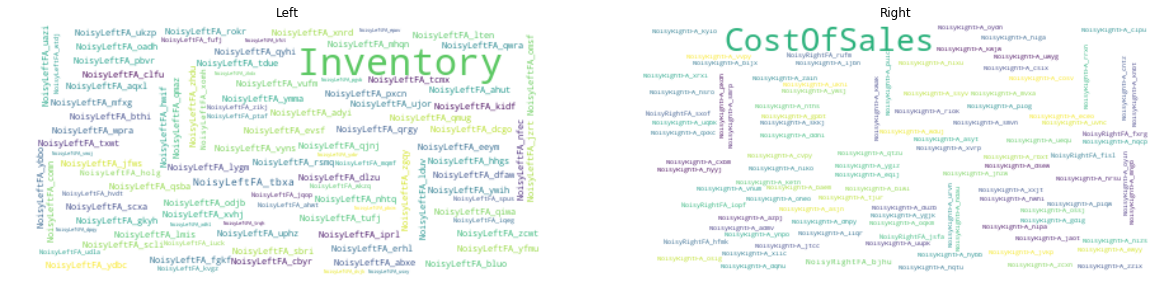

Current cluster label is  1
Left ---> [('Revenue', 598, 29855800.0), ('Tax', 598, 4023857.330460882)]
Right ---> [('TradeReceivables', 598, 33896815.1903523), ('NoisyRightFA_kfix', 8, 1187.7900593814434)]


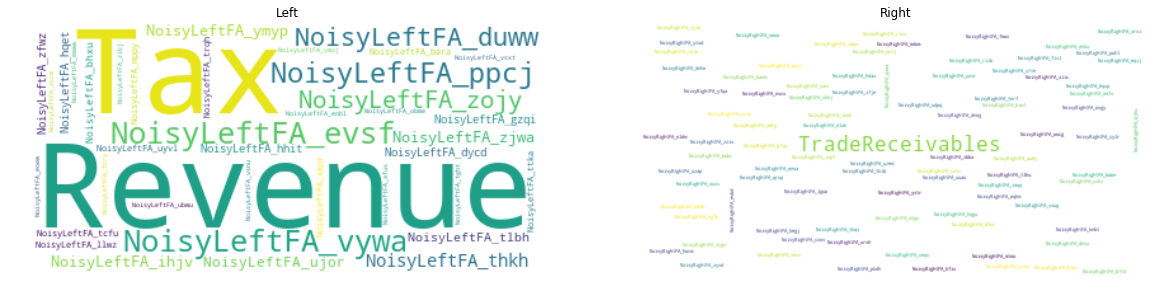

Current cluster label is  2
Left ---> [('Revenue', 815, 40818000.0), ('Tax', 815, 5449318.915404374)]
Right ---> [('TradeReceivables', 815, 46296777.14136057), ('NoisyRightFA_ejyk', 10, 1113.118024213949)]


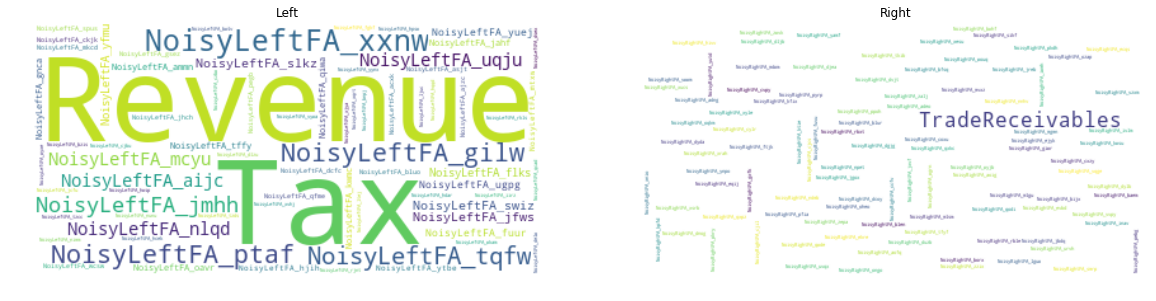

Current cluster label is  3
Left ---> [('EBPayables', 1060, 125359340.36614928), ('Tax', 1060, 33390000.0)]
Right ---> [('PersonnelExpenses', 1060, 159215265.6584286), ('NoisyRightFA_sajy', 14, 1303.7044787742807)]


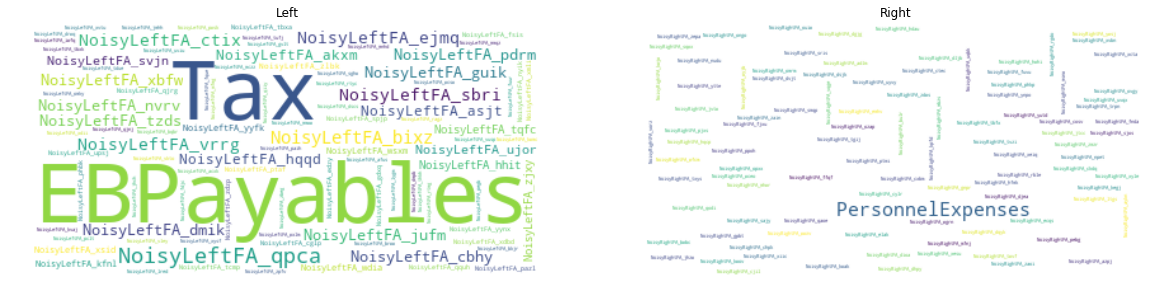

Current cluster label is  4
Left ---> [('TradeReceivables', 1172, 66115272.10944055), ('NoisyRightFA_urvh', 21, 2541.3172762118957)]
Right ---> [('Cash', 1172, 66673757.89423147)]


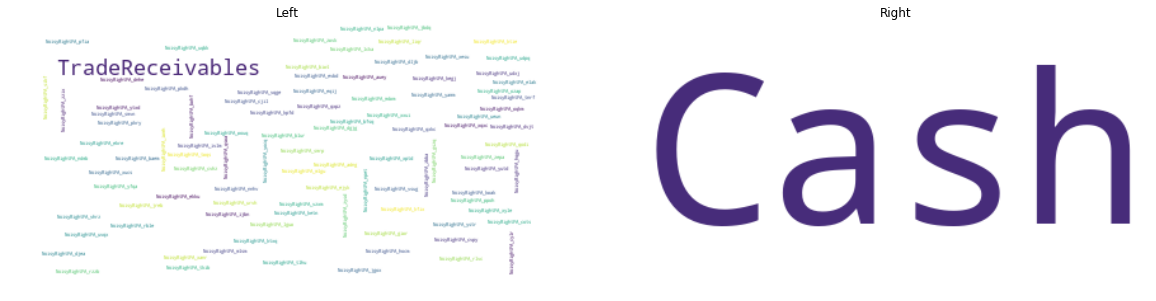

Current cluster label is  5
Left ---> [('FixedAssets', 410, 2210940.140707148), ('NoisyLeftFA_uioj', 6, 95.04441924788154)]
Right ---> [('DepreciationExpense', 410, 2214200.0), ('NoisyRightFA_phkp', 7, 114.77276275201008)]


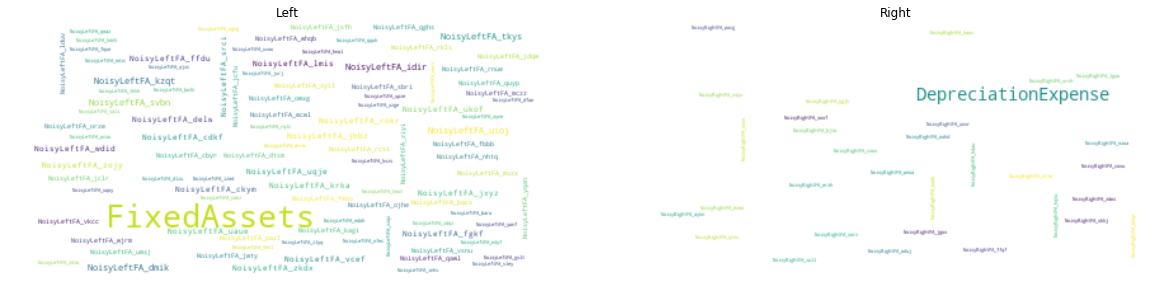

Current cluster label is  6
Left ---> [('OtherExpenses', 236, 1201100.0), ('PersonnelExpenses', 236, 1204800.0)]
Right ---> [('TradePayables', 236, 3571454.0159209436), ('NoisyRightFA_ital', 5, 214.06716628209273)]


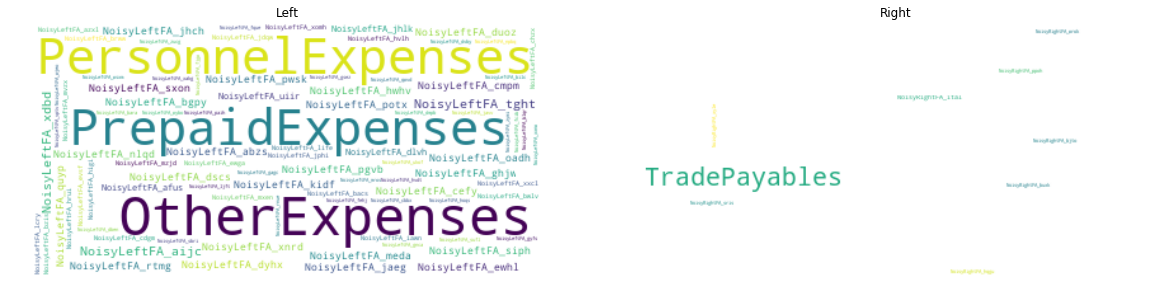

Current cluster label is  7
Left ---> [('TradePayables', 430, 2353200.0), ('NoisyLeftFA_vzfa', 7, 109.98534307047811)]
Right ---> [('FixedAssets', 430, 2357422.89149614), ('NoisyRightFA_dnhe', 10, 92.35911484288162)]


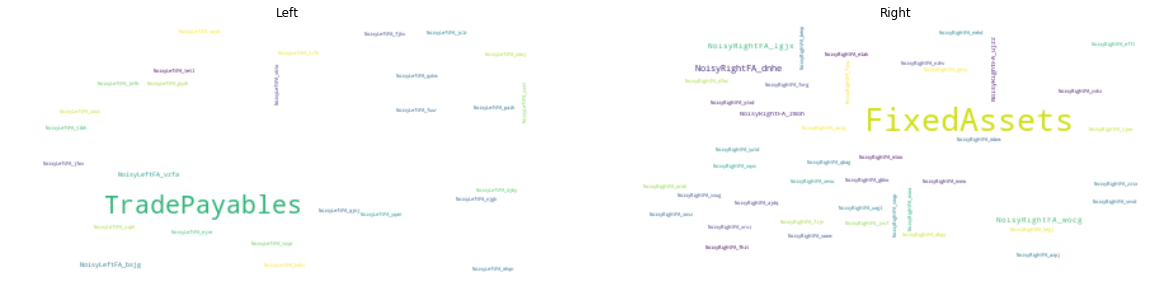

Current cluster label is  8
Left ---> [('Revenue', 460, 22586300.0), ('Tax', 460, 3111770.1766418116)]
Right ---> [('TradeReceivables', 460, 25688826.30736379), ('NoisyRightFA_urvh', 8, 1120.8896192267066)]


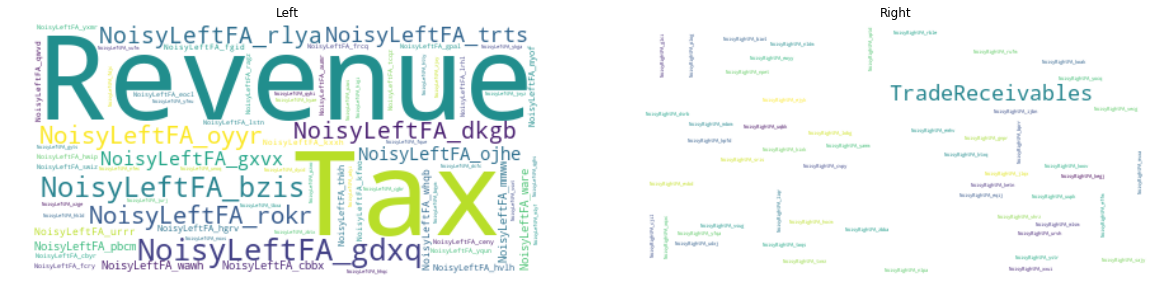

In [102]:
def findMostCommonFAs(df, labels_column="label", words_column="FA_Name", amount_column="amount", sort_mode="freq", n_top=2, vis=False):
    if vis:
        from wordcloud import WordCloud
    for name, group in df.groupby(labels_column):
        print("Current cluster label is ", name)
        cur_data = group.groupby(words_column, as_index=False)[amount_column].agg(sum)
        fa_amounts = dict(zip(cur_data[words_column].values, cur_data[amount_column].values))
        text = {"Left": [(item[0], item[1], fa_amounts[item[0]]) for item in Counter(group[group["from"] == True][words_column].values).items()], 
                "Right": [(item[0], item[1], fa_amounts[item[0]]) for item in Counter(group[group["from"] == False][words_column].values).items()]}
        if vis:
            i = 1
            fig = plt.figure()  
        for key, data in text.items():
            if sort_mode == "freq":
#             Take the most frequent FA names
                output = sorted(data, key=lambda d: -d[1])
                to_vis = [(item[0], item[1]) for item in output]
            elif sort_mode == "amount":
                output = sorted(data, key=lambda d: -d[2])
                to_vis = [(item[0], item[2]) for item in output]
            print(key, "--->", output[:n_top])
            if vis:
                ax = fig.add_subplot(1,2,i)
                i+=1
                ax.set_title(key)
                wc = WordCloud(background_color="white", repeat=False, relative_scaling=0.75, max_words=100)
                wc.generate_from_frequencies(dict(to_vis))
                ax.axis("off")
                ax.imshow(wc, interpolation="bilinear")
        if vis:
            plt.show()
# ----
findMostCommonFAs(w_cnt, "label", "FA_Name", sort_mode="freq", vis=True)

Current cluster label is  0
Left ---> [('Inventory', 1661), ('NoisyLeftFA_tbxa', 17)]
Right ---> [('CostOfSales', 1661), ('NoisyRightFA_bjhu', 20)]


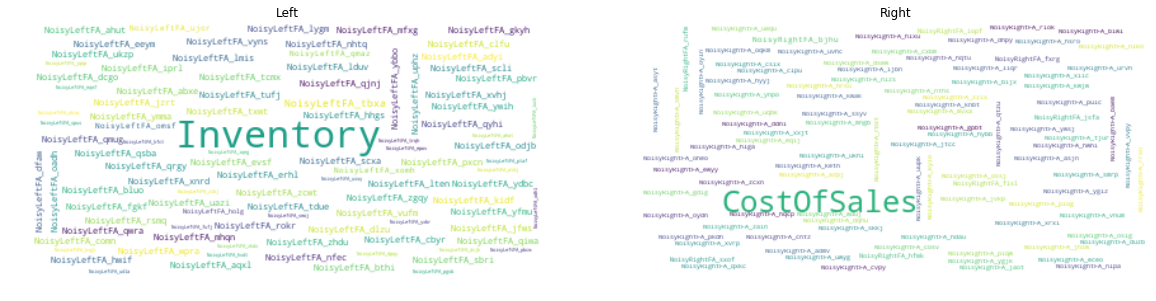

Current cluster label is  1
Left ---> [('Revenue', 598), ('Tax', 598)]
Right ---> [('TradeReceivables', 598), ('NoisyRightFA_kfix', 8)]


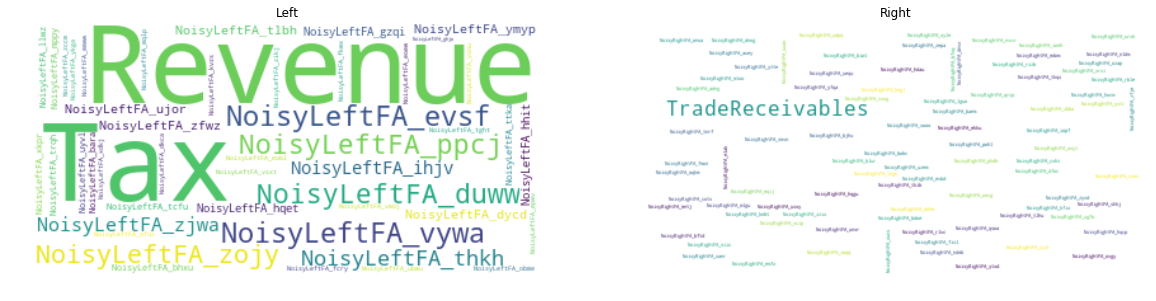

Current cluster label is  2
Left ---> [('Revenue', 815), ('Tax', 815)]
Right ---> [('TradeReceivables', 815), ('NoisyRightFA_ejyk', 10)]


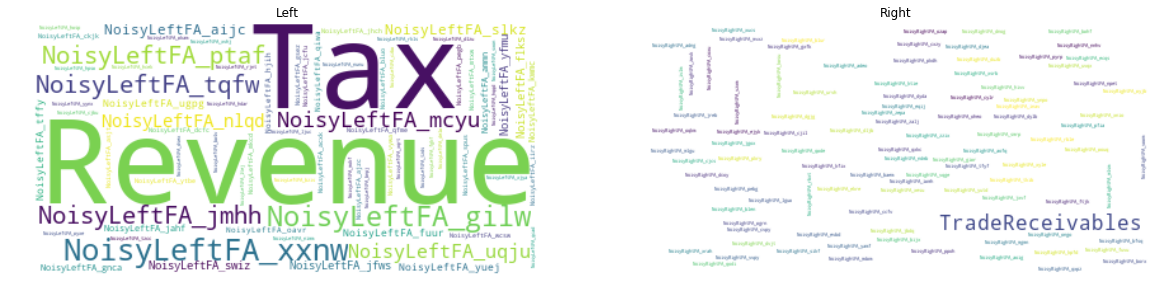

Current cluster label is  3
Left ---> [('EBPayables', 1060), ('Tax', 1060)]
Right ---> [('PersonnelExpenses', 1060), ('NoisyRightFA_sajy', 14)]


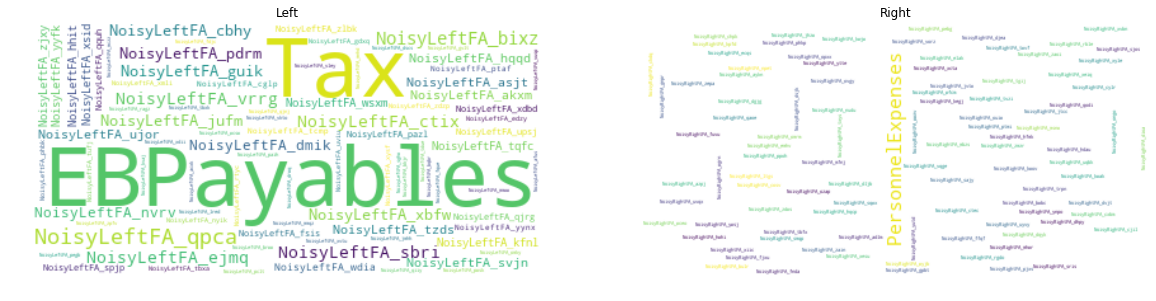

Current cluster label is  4
Left ---> [('TradeReceivables', 1172), ('NoisyRightFA_urvh', 21)]
Right ---> [('Cash', 1172)]


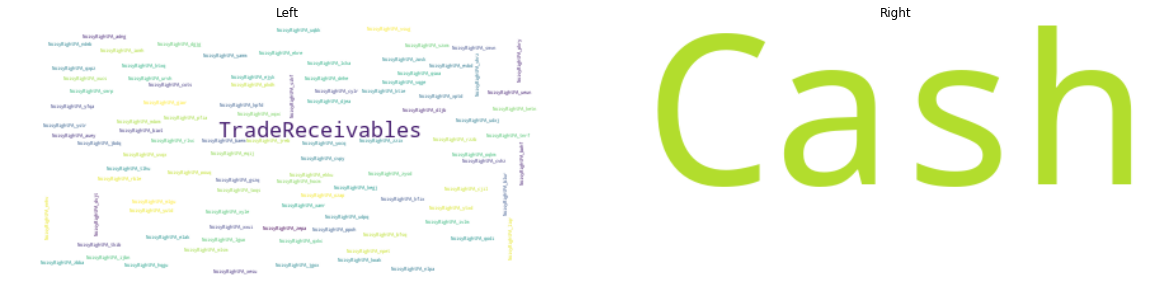

Current cluster label is  5
Left ---> [('FixedAssets', 410), ('NoisyLeftFA_uioj', 6)]
Right ---> [('DepreciationExpense', 410), ('NoisyRightFA_phkp', 7)]


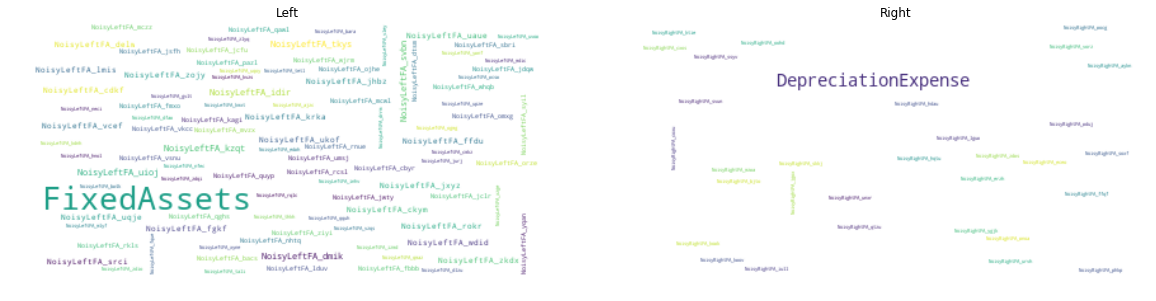

Current cluster label is  6
Left ---> [('OtherExpenses', 236), ('PersonnelExpenses', 236)]
Right ---> [('TradePayables', 236), ('NoisyRightFA_ital', 5)]


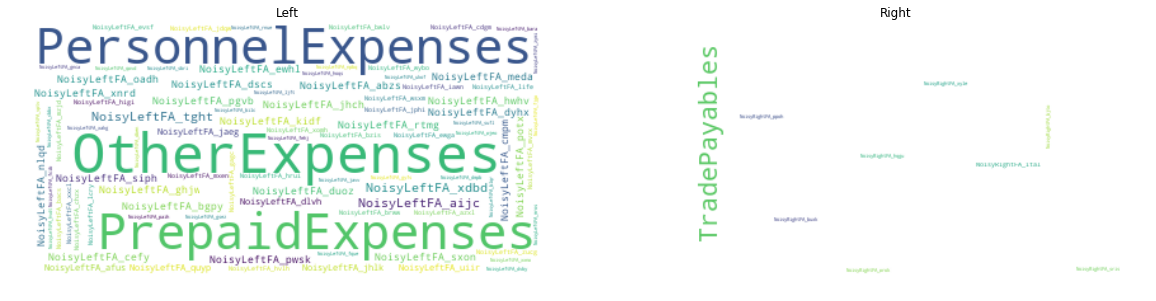

Current cluster label is  7
Left ---> [('TradePayables', 430), ('NoisyLeftFA_vzfa', 7)]
Right ---> [('FixedAssets', 430), ('NoisyRightFA_dnhe', 10)]


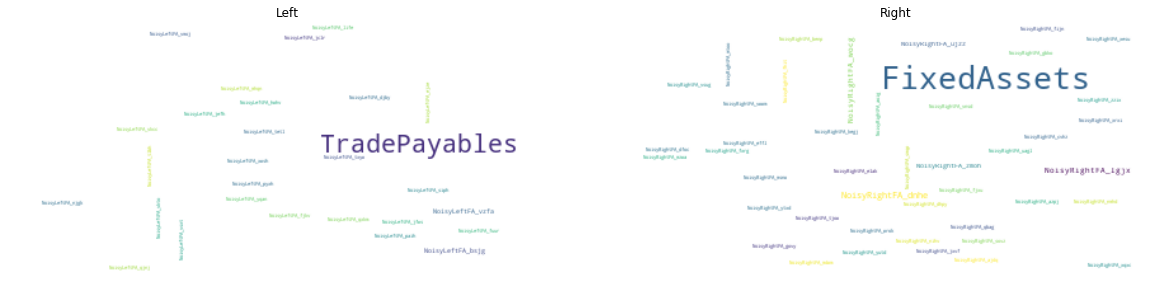

Current cluster label is  8
Left ---> [('Revenue', 460), ('Tax', 460)]
Right ---> [('TradeReceivables', 460), ('NoisyRightFA_urvh', 8)]


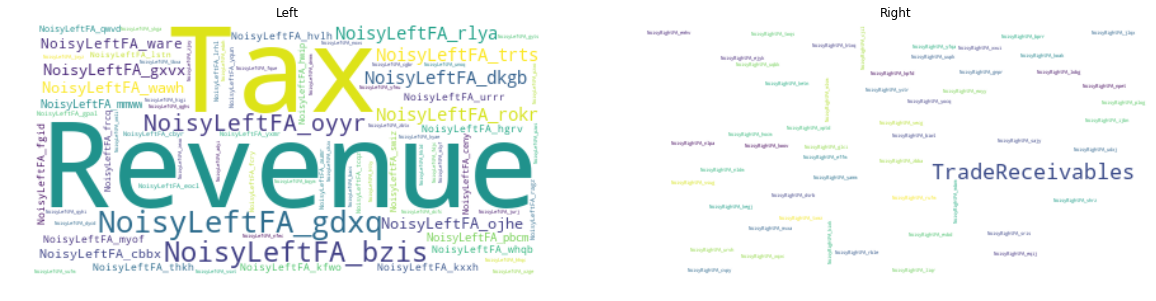

In [55]:
from wordcloud import WordCloud
n_top=2
for name, group in w_cnt.groupby("label"):
    print("Current cluster label is ", name)
    text = {"Left": Counter(group[group["from"] == True]["FA_Name"].values), 
               "Right": Counter(group[group["from"] == False]["FA_Name"].values)}
    i = 1
    fig = plt.figure()
    for key, data in text.items():
        print(key, "--->", data.most_common(n_top))
        ax = fig.add_subplot(1,2,i)
        i+=1
        ax.set_title(key)
        wc = WordCloud(background_color="white", repeat=False, relative_scaling=0.75, max_words=100)
        wc.generate_from_frequencies(data)
        ax.axis("off")
        ax.imshow(wc, interpolation="bilinear")
    plt.show()